# Seleção de Features c/ método wrapping: Recursive Feature Elimination

## Carregando as libs

In [38]:
from pandas import read_csv
from numpy import nan
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

## Carregando os dados

In [39]:
#Fonte: https://www.kaggle.com/uciml/pima-indians-diabetes-database
data = read_csv('pima-indians-diabetes.csv' , header=None)

In [40]:
## eliminando dados faltantes
data.iloc[:,:-1] = data.iloc[:,:-1].replace(0, nan)
data.dropna(inplace=True)

In [41]:
## Divisão treino/teste
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

<img src="feature_selection.png" width=600 height=600 />

## Selecionando as features com o wrapping

In [45]:
def select_features(x_train, y_train, x_test): 
    
    rfe = RFECV(estimator=DecisionTreeClassifier())
    rfe.fit(x_train, y_train)
    
    x_train_fs = rfe.transform(x_train)
    x_test_fs = rfe.transform(x_test)

    return x_train_fs, x_test_fs, rfe

In [46]:
def get_best_model(model_name, x, y):
    
    if model_name == 'd_tree':
        params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
        model = DecisionTreeClassifier()
    elif model_name == 'r_forest':
        params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 1, 3, 5, 7]}
        model = RandomForestClassifier()
    else:
        print("Oops! That was no valid model. Try again...")
    
    
    grid = GridSearchCV(model,           
                        params,          
                        error_score=0.)  
    grid.fit(x, y) 
    
    return grid

In [47]:
def evaluate_model(model, x_test, y_test):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_test, y_test, scoring= 'accuracy' , cv=cv, n_jobs=-1)
    return scores

## Realizando a classificação

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [49]:
# Seleção das features
x_train_fs, x_test_fs, fs = select_features(x_train, y_train, x_test)

# Capturar os melhores parâmetros do modelo
grid = get_best_model("r_forest", x_train_fs, y_train)

# Instanciar o modelo com os melhores parâmetros e treiná-lo
#model = DecisionTreeClassifier(**grid.best_params_)
model = RandomForestClassifier(**grid.best_params_)
model.fit(x_train_fs, y_train)

# Avaliando o modelo
scores = evaluate_model(model,x_test_fs,y_test)
print( '%s > %.3f (%.3f) ' % ("r_forest", mean(scores), std(scores)))

r_forest > 0.692 (0.066) 


# Importância das Características

In [50]:
model = RandomForestClassifier(criterion="gini")
model.fit(x_train, y_train)

RandomForestClassifier()

In [51]:
importance = model.feature_importances_
print(importance)

[0.07822236 0.24343578 0.08447087 0.08625918 0.15087778 0.09577617
 0.09176288 0.16919497]


In [52]:
model = RandomForestClassifier(criterion="entropy")
model.fit(x_train, y_train)
importance = model.feature_importances_
print(importance)

[0.07946067 0.22298848 0.08561818 0.08758341 0.17200004 0.10633933
 0.09203588 0.15397402]


In [53]:
from sklearn import svm
model = svm.SVC()
model.fit(x_train, y_train)

SVC()

In [54]:
importance = model.feature_importances_
print(importance)

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [55]:
# Feature Importance Permutation
from sklearn.inspection import permutation_importance
results = permutation_importance(model, x_train, y_train, scoring='accuracy')
importance = results.importances_mean

In [57]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.00224
Feature: 1, Score: 0.10448
Feature: 2, Score: 0.00075
Feature: 3, Score: 0.00970
Feature: 4, Score: 0.05746
Feature: 5, Score: -0.00075
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.02313


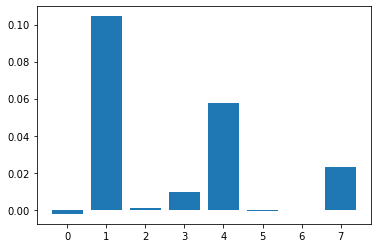

In [59]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Atividade (1.25): realizar a seleção de features com o RFECV atendendo aos seguintes itens:
<ol>
        <li> Modifique a função select_features para receber como parâmetro de entrada o nome do seletor (RFE, KBest e Feature Importance). Para o feature importance, use a função do sklearn SelectFromModel e defina o modelo e o número máximo de features de modo a resultar em uma acurácia média superior a 74%; </li> 
        <li> Plotar um boxplot da acurácia obtida pelos classificador para cada seletor de features. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior, contemplando os classificadores svm e gxboost;</li>    
</ol